<a href="https://colab.research.google.com/github/muxin3/gitskills/blob/main/CIFAR100_with_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [43]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [44]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [45]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 20

In [46]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [47]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

In [48]:
data_sets = {
    'train': torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='data', download=True, transform=data_transforms['test'])
}

Files already downloaded and verified
Files already downloaded and verified


In [49]:
print(data_sets['train'])
print('='*85)
print(data_sets['test'])

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [50]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}

In [51]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [52]:
model = models.resnet50(pretrained=True)

model = model.cuda() if use_cuda else model

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 20 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])

        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), 'models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch 0

Epoch [0/19], Step [0/782], Loss: 4.6283
Epoch [0/19], Step [20/782], Loss: 4.6231
Epoch [0/19], Step [40/782], Loss: 4.5764
Epoch [0/19], Step [60/782], Loss: 4.6228
Epoch [0/19], Step [80/782], Loss: 4.5800
Epoch [0/19], Step [100/782], Loss: 4.5546
Epoch [0/19], Step [120/782], Loss: 4.5306
Epoch [0/19], Step [140/782], Loss: 4.5341
Epoch [0/19], Step [160/782], Loss: 4.4620
Epoch [0/19], Step [180/782], Loss: 4.3802
Epoch [0/19], Step [200/782], Loss: 4.3539
Epoch [0/19], Step [220/782], Loss: 4.2967
Epoch [0/19], Step [240/782], Loss: 4.1798
Epoch [0/19], Step [260/782], Loss: 4.1018
Epoch [0/19], Step [280/782], Loss: 3.8067
Epoch [0/19], Step [300/782], Loss: 4.0132
Epoch [0/19], Step [320/782], Loss: 3.6900
Epoch [0/19], Step [340/782], Loss: 3.3516
Epoch [0/19], Step [360/782], Loss: 3.7226
Epoch [0/19], Step [380/782], Loss: 3.5164
Epoch [0/19], Step [400/782], Loss: 3.4403
Epoch [0/19], Step [420/782], Loss: 3.3053
Epoch [0/19], Step [440/782], Loss: 3.5002
Epoch [0

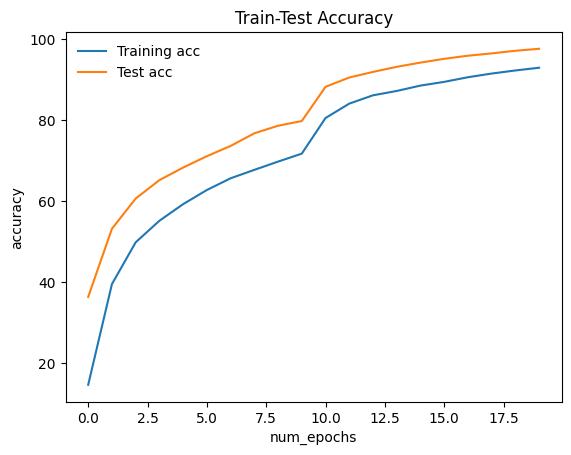

In [54]:
plt.title("Train-Test Accuracy")
plt.plot([x.cpu() for x in train_acces], label='Training acc')
plt.plot([x.cpu() for x in test_acces], label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show()

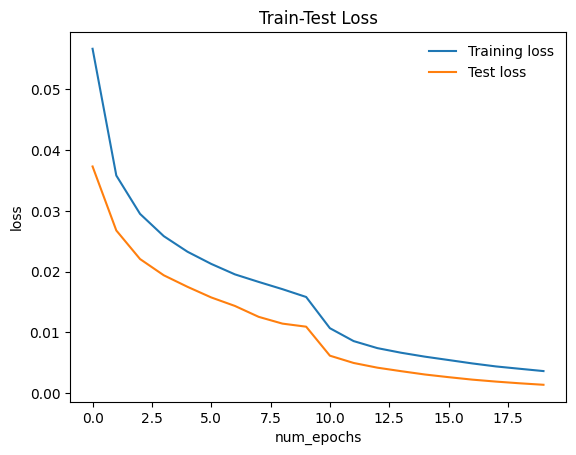

In [55]:
plt.title("Train-Test Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()

In [56]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
num = 20
classes = data_sets['test'].classes
indices = list(range(len(data_sets['test'])))
np.random.shuffle(indices)
idx = indices[:num]
from torch.utils.data.sampler import SubsetRandomSampler
sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data_sets['test'], sampler=sampler, batch_size=num)
dataiter = iter(loader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

In [58]:
def imshow(inp, title=None):

    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

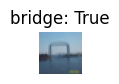

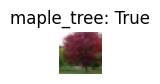

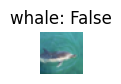

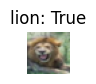

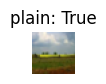

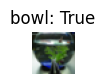

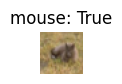

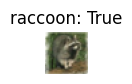

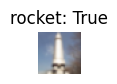

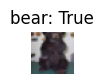

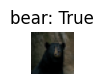

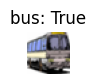

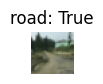

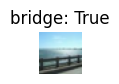

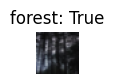

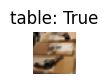

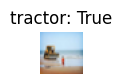

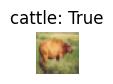

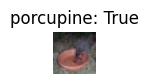

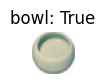

In [59]:
plt.ion()

if use_cuda:
    images, labels = images.cuda(), labels.cuda()

outputs = model(images)
_, preds = torch.max(outputs.data, 1)
preds = preds.cpu().numpy() if use_cuda else preds.numpy()

images_so_far = 0
for i in range(num):
    images_so_far += 1
    ax = plt.subplot(2, 20//2, images_so_far)
    ax.axis('off')
    res = preds[i] == labels[i]
    ax.set_title('{}: {}'.format(classes[preds[i]], res))
    imshow(images[i])

plt.ioff()